In [1]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import os
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pyproj
from scipy.interpolate import griddata
import cftime
from sklearn.linear_model import LinearRegression
import cartopy.feature as cfeature

In [2]:
home_path = os.path.expanduser("~")

path = '/DataFiles'
path2 = '/Library/Mobile Documents/com~apple~CloudDocs/Documents/Documents - MacBook Air/Python/Ice Cores/data/model/ccsm4_last_millenium'

racmo = xr.open_dataset(home_path + path + "/smb_monthlyS_ANT27_ERA5-3H_RACMO2.3p2_197901_202212.nc")
mask = xr.open_dataset(home_path + path + "/TotIS_RACMO_ANT27_IMBIE2.nc")

In [3]:
# Extract coordinate arrays
lat_attr = np.array(mask.GroundedIce.attrs["lat2d"])
lon_attr = np.array(mask.GroundedIce.attrs["lon2d"])

# Reshape to 2D
nlat, nlon = mask.dims["lat"], mask.dims["lon"]
lats2d = lat_attr.reshape(nlat, nlon)
lons2d = lon_attr.reshape(nlat, nlon)

# Attach as coordinates
basins = mask["GroundedIce"].copy()
basins = basins.assign_coords(lat=(("lat", "lon"), lats2d),
                              lon=(("lat", "lon"), lons2d))

/var/folders/4d/5th1wr_s21g614c74mcbh9kc0000gn/T/ipykernel_16836/630878015.py:6: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlat, nlon = mask.dims["lat"], mask.dims["lon"]


/opt/anaconda3/envs/cfr-env/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)
/opt/anaconda3/envs/cfr-env/lib/python3.13/site-packages/shapely/creation.py:730: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, np.intc(typ), out=out, **kwargs)


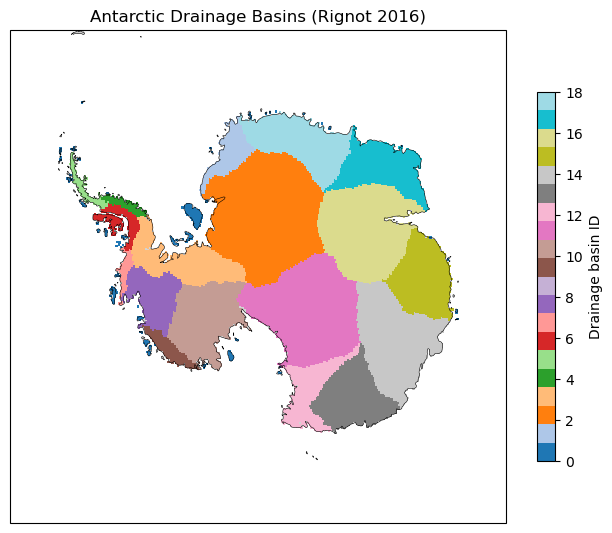

In [4]:
proj = ccrs.SouthPolarStereo()
data_crs = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': proj})
ax.set_extent([-180, 180, -90, -60], crs=data_crs)

ax.add_feature(cfeature.COASTLINE, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Filled basins
im = ax.pcolormesh(
    basins.lon, basins.lat, basins,
    transform=data_crs,
    cmap='tab20'
)


plt.colorbar(im, ax=ax, shrink=0.6, label="Drainage basin ID")
ax.set_title("Antarctic Drainage Basins (Rignot 2016)", fontsize=12)
plt.show()

In [5]:
print(racmo)

<xarray.Dataset> Size: 134MB
Dimensions:       (time: 528, nblock1: 40, nblock2: 400, bnds: 2, rlat: 240,
                   rlon: 262, height: 1)
Coordinates:
  * height        (height) float64 8B 0.0
    lat           (rlat, rlon) float64 503kB ...
    lon           (rlat, rlon) float64 503kB ...
  * rlat          (rlat) float64 2kB -30.0 -29.75 -29.5 ... 29.25 29.5 29.75
  * rlon          (rlon) float64 2kB -32.75 -32.5 -32.25 ... 32.0 32.25 32.5
  * time          (time) datetime64[ns] 4kB 1979-01-16 ... 2022-12-16
Dimensions without coordinates: nblock1, nblock2, bnds
Data variables:
    assigned      (time) int32 2kB ...
    block1        (nblock1) int32 160B ...
    block2        (nblock2) int32 2kB ...
    date_bnds     (time, bnds) int32 4kB ...
    dir           (rlat, rlon) float64 503kB ...
    dtg           (time) int32 2kB ...
    hms_bnds      (time, bnds) int32 4kB ...
    rotated_pole  float32 4B ...
    smb           (time, height, rlat, rlon) float32 133MB ...
    tim

In [32]:
print(smb)

<xarray.DataArray 'smb' (time: 528, rlat: 240, rlon: 262)> Size: 133MB
[33200640 values with dtype=float32]
Coordinates:
    height   float64 8B 0.0
    lat      (rlat, rlon) float64 503kB -46.75 -46.92 -47.09 ... -47.24 -47.07
    lon      (rlat, rlon) float64 503kB -126.9 -127.1 -127.3 ... 53.03 53.23
  * rlat     (rlat) float64 2kB -30.0 -29.75 -29.5 -29.25 ... 29.25 29.5 29.75
  * rlon     (rlon) float64 2kB -32.75 -32.5 -32.25 -32.0 ... 32.0 32.25 32.5
  * time     (time) datetime64[ns] 4kB 1979-01-16 ... 2022-12-16
Attributes:
    grid_mapping:   rotated_pole
    long_name:       Surface Mass Balance ice sheet
    standard_name:  smb
    cell_methods:   time: summed values time: mean
    units:          kg m-2


In [20]:
smb = racmo["smb"].squeeze("height")
smb_total = smb.groupby("time.year").sum(dim="time")
smb_ann = smb_total.sel(year=slice(1979, 2000))

basin_mask = mask["GroundedIce"]  # (lat, lon)
basin_mask = basin_mask.where(basin_mask != 0)  # ignore 0/non-grounded ice

basin_mask_aligned = mask["GroundedIce"].rename({"lat": "rlat", "lon": "rlon"})


n_years = smb_ann.sizes["year"]
nlat, nlon = smb_ann.sizes["rlat"], smb_ann.sizes["rlon"]

smb_flat = smb_ann.values.reshape(n_years, nlat*nlon)  # shape: (22, 240*262)
basin_flat = mask["GroundedIce"].values.reshape(nlat*nlon)  # shape: (240*262,)

valid_mask = ~np.isnan(basin_flat) & (basin_flat != 0)
basin_ids = basin_flat[valid_mask].astype(int)

smb_df = pd.DataFrame(smb_flat[:, valid_mask].T, index=basin_ids)

annual_smb_per_basin = smb_df.groupby(smb_df.index).sum()
annual_smb_per_basin = annual_smb_per_basin.T

In [15]:
print(annual_smb_per_basin)

              1              2              3             4              5   \
0   60838.726562  121510.882812  169590.593750  26488.304688  151552.000000   
1   57357.773438  119702.000000  138562.140625  26240.230469   96384.859375   
2   85677.765625  159498.468750  183105.562500  30982.972656  136178.843750   
3   87113.578125  178033.515625  200093.671875  29368.029297  150833.750000   
4   61906.843750  116505.359375  194824.734375  35856.222656  161544.640625   
5   59560.937500  146476.531250  214134.750000  32786.378906  146570.609375   
6   62613.746094  158271.265625  225464.546875  28459.378906  148693.078125   
7   70169.031250  143922.171875  169794.328125  29938.087891  126880.648438   
8   63179.335938  114947.109375  209435.812500  39767.191406  137592.937500   
9   68277.882812  137947.421875  186418.328125  30891.367188  116260.851562   
10  77292.523438  143209.296875  207558.671875  35187.988281  161522.265625   
11  84513.882812  148228.656250  210946.562500  3401

In [17]:
import numpy as np
import xarray as xr
import pyproj

# Extract lat/lon arrays
lat = racmo["lat"].values
lon = racmo["lon"].values

# Define Antarctic polar stereographic projection
# Parameters from standard EPSG:3031
proj = pyproj.Proj(proj='stere', lat_0=-90, lon_0=0, lat_ts=-71, ellps='WGS84')

# Project the 2D grid
x, y = proj(lon, lat)  # x, y in meters, shape = (rlat, rlon)

# Differences along axes
dx = np.diff(x, axis=1)  # differences along rlon (columns), shape (rlat, rlon-1)
dy = np.diff(y, axis=0)  # differences along rlat (rows), shape (rlat-1, rlon)

# Approximate cell area as dx * dy
# Take inner product to match shapes: (rlat-1, rlon-1)
cell_area = dx[:-1, :] * dy[:, :-1]

# Convert to xarray DataArray
cell_area_da = xr.DataArray(cell_area, dims=("rlat","rlon"))
print(cell_area_da.shape)


(239, 261)


In [15]:
print(cell_area_da)

<xarray.DataArray (rlat: 239, rlon: 261)> Size: 499kB
array([[2.52271575e+08, 2.55299288e+08, 2.58353226e+08, ...,
        2.62143724e+08, 2.59062024e+08, 2.56006522e+08],
       [2.50513263e+08, 2.53537337e+08, 2.56588026e+08, ...,
        2.60370872e+08, 2.57291981e+08, 2.54239690e+08],
       [2.48723150e+08, 2.51743066e+08, 2.54789984e+08, ...,
        2.58564564e+08, 2.55489006e+08, 2.52440448e+08],
       ...,
       [2.46984704e+08, 2.50018502e+08, 2.53080287e+08, ...,
        2.56866139e+08, 2.53774619e+08, 2.50711107e+08],
       [2.48832588e+08, 2.51871404e+08, 2.54937820e+08, ...,
        2.58732964e+08, 2.55637248e+08, 2.52569142e+08],
       [2.50648763e+08, 2.53692059e+08, 2.56762567e+08, ...,
        2.60566369e+08, 2.57467001e+08, 2.54394841e+08]], shape=(239, 261))
Dimensions without coordinates: rlat, rlon


Text(0.5, 1.0, 'RACMO2 Grid Cell Area (Grounded Ice)')

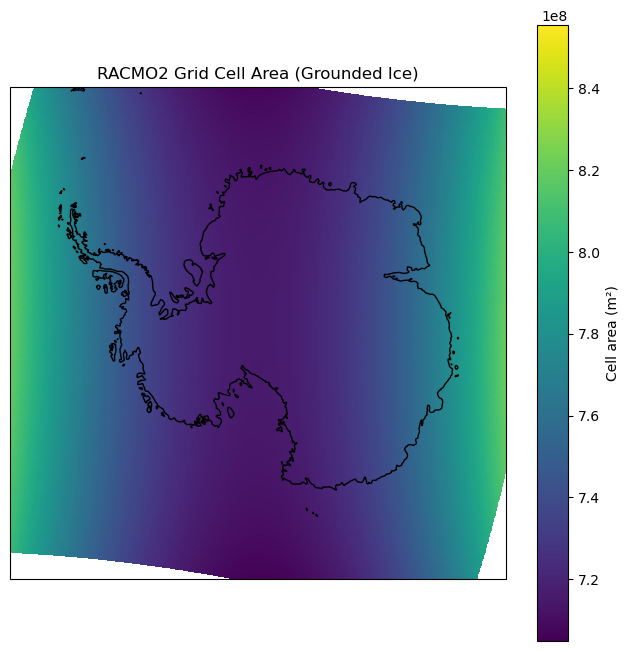

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# cell_area_da should be your xarray DataArray in m²
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_extent([-180, 180, -90, -60], crs=ccrs.PlateCarree())

# Optional: add coastlines and land
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="white")
ax.coastlines(resolution="50m")

# Plot the cell areas
mesh = ax.pcolormesh(
    racmo["lon"], racmo["lat"], cell_area_da,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    shading="auto"
)

# Colorbar
cbar = plt.colorbar(mesh, ax=ax, orientation="vertical", pad=0.05)
cbar.set_label("Cell area (m²)")

plt.title("RACMO2 Grid Cell Area (Grounded Ice)")


In [21]:
smb_1979 = smb_ann.sel(year=1979)
smb_mass_1979 = smb_1979 * cell_area  # kg per grid cell



ValueError: operands could not be broadcast together with shapes (240,262) (239,261) 

In [23]:
# cell_area_da shape: (239, 261)
area = cell_area_da.values

# Duplicate last row
area_full = np.vstack([area, area[-1:, :]])  # shape: (240, 261)

# Duplicate last column
area_full = np.hstack([area_full, area_full[:, -1:]])  # shape: (240, 262)

# Convert back to DataArray with original dims
cell_area_da_full = xr.DataArray(area_full, dims=("rlat","rlon"))
print(cell_area_da_full.shape)  # (240, 262)

smb_1979 = smb_ann.sel(year=1979)  # shape (240, 262), kg/m²

# Mass per grid cell in kg
smb_mass_1979 = smb_1979 * cell_area_da_full

# Antarctic-wide total in Gt
antarctic_smb_Gt = smb_mass_1979.sum() / 1e12
print("Total Antarctic SMB 1979 [Gt]:", antarctic_smb_Gt.values)


(240, 262)
Total Antarctic SMB 1979 [Gt]: 2350.082773720649


In [42]:
smb_mass = smb_1979 * cell_area  # kg per grid cell
antarctic_smb_Gt = annual_smb_per_basin_1979.sum() / 1e12  # convert kg → Gt

In [43]:
print(antarctic_smb_Gt)

1      36.248561
2      72.323822
3       2.960083
4       1.604207
5       7.624853
6       4.309170
7       2.205572
8      33.436014
9      53.367800
10     66.300143
11    112.332333
12     31.318893
13     53.226021
14     24.871936
15      4.913022
16     23.412792
17     67.505147
18     81.208292
dtype: float64


In [20]:
smb_flat_1979 = smb_mass_1979.values.reshape(nlat*nlon)  # shape: (22, 240*262)
basin_flat = mask["GroundedIce"].values.reshape(nlat*nlon)  # shape: (240*262,)

valid_mask = ~np.isnan(basin_flat) & (basin_flat != 0)
basin_ids = basin_flat[valid_mask].astype(int)

smb_df_1979 = pd.DataFrame(smb_flat_1979[valid_mask].T, index=basin_ids)

annual_smb_per_basin_1979 = smb_df_1979.groupby(smb_df_1979.index).sum()
annual_smb_per_basin_1979 = annual_smb_per_basin_1979.T

In [21]:
smb_mass = smb_1979 * cell_area  # kg per grid cell
antarctic_smb_Gt = annual_smb_per_basin_1979.sum() / 1e12  # convert kg → Gt

In [23]:
print(antarctic_smb_Gt.sum)

<bound method Series.sum of 1      36.248561
2      72.323822
3       2.960083
4       1.604207
5       7.624853
6       4.309170
7       2.205572
8      33.436014
9      53.367800
10     66.300143
11    112.332333
12     31.318893
13     53.226021
14     24.871936
15      4.913022
16     23.412792
17     67.505147
18     81.208292
dtype: float64>


In [8]:
n_years = smb_ann.sizes["year"]
nlat, nlon = smb_ann.sizes["rlat"], smb_ann.sizes["rlon"]

smb_flat = smb_ann.values.reshape(n_years, nlat*nlon)       # (years, points)
basin_flat = mask["GroundedIce"].values.reshape(nlat*nlon) # (points,)
area_flat = cell_area.reshape(nlat*nlon)                   # (points,)

valid_mask = ~np.isnan(basin_flat) & (basin_flat != 0)
basin_ids = basin_flat[valid_mask].astype(int)
smb_valid = smb_flat[:, valid_mask]  # (years, valid_points)
area_valid = area_flat[valid_mask]   # (valid_points,)

NameError: name 'cell_area' is not defined

In [9]:
valid_mask = ~np.isnan(basin_flat) & (basin_flat != 0)
basin_ids = basin_flat[valid_mask].astype(int)
smb_valid = smb_flat[:, valid_mask]  # (years, valid_points)
area_valid = area_flat[valid_mask]   # (valid_points,)

NameError: name 'area_flat' is not defined

In [26]:
smb_mass = smb_valid * area_valid[np.newaxis, :]  # shape (years, valid_points)

In [28]:
# Build DataFrame: rows = grid points, columns = years
smb_df = pd.DataFrame(smb_mass.T, index=basin_ids)  # shape: (points, years)

# Group by basin and sum over grid points
annual_smb_mass_per_basin = smb_df.groupby(smb_df.index).sum()  # (basin, years)

# Transpose so years are rows, basins are columns
annual_smb_mass_per_basin = annual_smb_mass_per_basin.T / 1e12

print(annual_smb_mass_per_basin.shape)  # (22, N_basins)
print(annual_smb_mass_per_basin.head())

(22, 18)
          1           2         3         4         5         6         7   \
0  36.248561   72.323822  2.960083  1.604207  7.624853  4.309170  2.205572   
1  33.481291   71.856419  2.812947  1.609664  5.173780  2.517028  1.561223   
2  51.110757   94.458859  3.280163  1.899838  7.133170  3.922477  2.143877   
3  51.166943  100.073133  3.691500  1.788548  7.675293  4.682077  2.229565   
4  36.792672   69.286280  3.317064  2.197726  8.221726  4.331531  2.341224   

          8          9           10          11         12         13  \
0  33.436014  53.367800   66.300143  112.332333  31.318893  53.226021   
1  32.735338  93.265401  130.395763  206.070157  31.684956  66.377120   
2  34.971969  64.693996   66.688434  162.842854  32.515538  71.247653   
3  35.209506  64.878218   79.476522  137.792735  39.664867  57.854387   
4  34.990807  50.403380   54.224165  132.575358  51.868380  72.823478   

          14        15         16         17          18  
0  24.871936  4.913022  

In [29]:
antarctic_smb_Gt = annual_smb_mass_per_basin.sum(axis=1)
print(antarctic_smb_Gt)

0     679.168658
1     896.513614
2     881.155037
3     820.300354
4     709.863852
5     804.415113
6     758.443953
7     762.150341
8     680.842931
9     777.459094
10    697.706227
11    722.840497
12    815.530008
13    896.434379
14    853.019057
15    784.804208
16    778.223164
17    709.219137
18    781.070856
19    772.433985
20    729.417481
21    748.490764
dtype: float64


In [30]:
# Flatten SMB
smb_flat = smb_ann.values.reshape(n_years, nlat*nlon)
basin_flat = mask["GroundedIce"].values.reshape(nlat*nlon)

# Only grounded ice
valid_mask = ~np.isnan(basin_flat) & (basin_flat != 0)
smb_valid = smb_flat[:, valid_mask]

# Approximate cell area in m² (uniform)
dx = 11000  # meters
dy = 11000
cell_area = dx * dy

# Total mass per year in kg
total_mass_kg = (smb_valid * cell_area).sum(axis=1)

# Convert to Gt
total_mass_Gt = total_mass_kg / 1e12

In [37]:
# Squeeze height dimension
smb = racmo["smb"].squeeze("height")  # (time, rlat, rlon)

# Annual SMB 1979–2000
smb_total = smb.groupby("time.year").sum(dim="time")
smb_ann = smb_total.sel(year=slice(1979, 2000))  # (year, rlat, rlon)

# Grounded ice mask (non-NaN, nonzero)
grounded_mask = ~np.isnan(mask["GroundedIce"]) & (mask["GroundedIce"] != 0)
basin_ids = mask["GroundedIce"].where(grounded_mask)

In [39]:
# Get grid shape
nrlat = racmo.sizes["rlat"]
nrlon = racmo.sizes["rlon"]

# Create an array of the same shape
cell_area_array = np.full((nrlat, nrlon), dx * dy)  # m² per cell

# Convert to DataArray
cell_area_da = xr.DataArray(cell_area_array, dims=("rlat","rlon"))

# Apply grounded ice mask
cell_area_da = cell_area_da.where(grounded_mask)


In [40]:
# Shape: (year, rlat, rlon)
smb_mass = smb_ann * cell_area_da  # kg per cell

# Convert to Gt
smb_mass_Gt = smb_mass / 1e12


: 

In [11]:
print(cell_area)

121000000


In [10]:
import numpy as np
import pandas as pd
import xarray as xr

# --- Step 0: Define parameters ---
dx = 11000  # meters (approx grid spacing)
dy = 11000
cell_area = dx * dy  # m² per grid cell

# Flattened grid size
nlat = smb_ann.sizes["rlat"]
nlon = smb_ann.sizes["rlon"]

# Flatten the basin mask
basin_flat = mask["GroundedIce"].values.reshape(nlat * nlon)
valid_mask = ~np.isnan(basin_flat) & (basin_flat != 0)
basin_ids = basin_flat[valid_mask].astype(int)

# --- Step 1: Loop over years and compute per-basin and Antarctic SMB ---
years = smb_ann.year.values
annual_smb_per_basin_list = []
antarctic_smb_list = []

for yr in years:
    print(yr)
    smb_year = smb_ann.sel(year=yr)
    smb_mass = smb_year * cell_area  # kg per cell

    # Flatten and keep only valid points
    smb_flat = smb_mass.values.reshape(nlat * nlon)[valid_mask]

    # Per-basin sum
    df = pd.DataFrame({"basin": basin_ids, "smb": smb_flat})
    df_grouped = df.groupby("basin")["smb"].sum()
    annual_smb_per_basin_list.append(df_grouped)

    # Antarctic-wide total in Gt
    antarctic_total = df_grouped.sum() / 1e12
    antarctic_smb_list.append(antarctic_total)

# --- Step 2: Combine per-basin results into DataFrame ---
annual_smb_per_basin = pd.concat(annual_smb_per_basin_list, axis=1)
annual_smb_per_basin.columns = years
annual_smb_per_basin = annual_smb_per_basin.T  # rows = years, columns = basins

# --- Step 3: Antarctic-wide SMB ---
antarctic_smb_Gt = pd.Series(antarctic_smb_list, index=years)
print(antarctic_smb_Gt)
print(f"Mean Antarctic SMB (1979–2000): {antarctic_smb_Gt.mean():.1f} Gt/yr")


1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
1979    303.978882
1980    330.289001
1981    353.580841
1982    342.583771
1983    319.254089
1984    349.528992
1985    343.356995
1986    317.848358
1987    296.703857
1988    316.896301
1989    316.960327
1990    311.826050
1991    330.004913
1992    350.893341
1993    336.579163
1994    302.532532
1995    318.019196
1996    323.470947
1997    308.313904
1998    336.284943
1999    318.828003
2000    316.418701
dtype: float32
Mean Antarctic SMB (1979–2000): 324.7 Gt/yr
